In [40]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import nltk
import networkx as nx
import sys
import matplotlib.pyplot as plt
import pickle
import community.community_louvain as community_louvain
from collections import defaultdict
import matplotlib.cm as cm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions 
from wordcloud import WordCloud
from collections import Counter


In [41]:
# Download NLTK stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/alesac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load data

In [42]:
ts_data = pd.read_csv('data/taylor_swift_discography_updated.csv', sep=';', index_col = 'ID')
ts_data.head()

,track_name,track_musical_genre,track_type,duration_ms,feature,track_videoclip,videoclip_views,spotify_streams,spotify_global_peak,album,track_number,album_musical_genre,album_type,release_date,album_physical_sales,track_lyrics,track_theme,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Fortnight (feat. Post Malone),Synth Pop,Single,228965,Post Malone,No,0,648525069,1,The Tortured Poets Department: The Anthology,1,Pop,Compilation/Deluxe,19/4/2024,0,I was supposed to be sent away But they forgot to come and get me I was a functioning alcoholic 'Til nobody noticed my new aesthetic All of this to say I hope you're okay But you're the reason And...,Complicated love/Looking for love,spotify:track:6dODwocEuGzHAavXqTbwHv,0.5020,0.504,0.386,1.53e-05,0.0961,-10.976,0.0308,192.004,0.281
1,The Tortured Poets Department,Synth Pop,B-Side,293048,No,No,0,206954130,6,The Tortured Poets Department: The Anthology,2,Pop,Compilation/Deluxe,19/4/2024,0,"You left your typewriter at my apartment Straight from the tortured poets department I think some things I never say Like, ""Who uses typewriters anyway?"" But you're in self-sabotage mode Throwing ...",Complicated love/Looking for love,spotify:track:4PdLaGZubp4lghChqp8erB,0.0483,0.604,0.428,0.0,0.1260,-8.441,0.0255,110.259,0.292
2,My Boy Only Breaks His Favorite Toys,Synth Pop,B-Side,203801,No,No,0,238016975,7,The Tortured Poets Department: The Anthology,3,Pop,Compilation/Deluxe,19/4/2024,0,"Oh, here we go again. The voices in his head Called the rain to end our days of wild The sickest army doll Purchased at the mall Rivulets descend my plastic smile But you should've seen him When h...",Broken heart/Sadness,spotify:track:7uGYWMwRy24dm7RUDDhUlD,0.1370,0.596,0.563,0.0,0.3020,-7.362,0.0269,97.073,0.481
3,Down Bad,R&B,B-Side,261228,No,No,0,318375377,2,The Tortured Poets Department: The Anthology,4,Pop,Compilation/Deluxe,19/4/2024,0,Did you really beam me up? In a cloud of sparkling dust Just to do experiments on Tell me I was the chosen one Show me that this world is bigger than us Then sent me back where I came from For a m...,Broken heart/Sadness,spotify:track:1kbEbBdEgQdQeLXCJh28pJ,0.5600,0.541,0.366,"1,00E-06",0.0946,-10.412,0.0748,159.707,0.168
4,"So Long, London",Synth Pop,B-Side,262974,No,No,0,253712712,4,The Tortured Poets Department: The Anthology,5,Pop,Compilation/Deluxe,19/4/2024,0,I saw in my mind fairy lights through the mist I kept calm and carried the weight of the rift Pulled him in tighter each time he was drifting away My spine split from carrying us up the hill Wet t...,Broken heart/Sadness,spotify:track:7wAkQFShJ27V8362MqevQr,0.7300,0.423,0.533,0.00264,0.0816,-11.388,0.3220,160.218,0.248


In [43]:
#print size of the dataset
rows, columns = ts_data.shape
print('Number of rows: ', rows)
print('Number of columns: ', columns)

Number of rows:  577
Number of columns:  27


In [44]:
# print name of columns
print(ts_data.columns)

Index(['track_name', 'track_musical_genre', 'track_type', 'duration_ms',
       'feature', 'track_videoclip', 'videoclip_views', 'spotify_streams',
       'spotify_global_peak', 'album', 'track_number', 'album_musical_genre',
       'album_type', 'release_date', 'album_physical_sales', 'track_lyrics',
       'track_theme', 'uri', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence'],
      dtype='object')


In [45]:
# change the type of certain columns of the dataset
ts_data['release_date'] = pd.to_datetime(ts_data['release_date'], format='%d/%m/%Y')
ts_data['spotify_streams'] = ts_data['spotify_streams'].str.replace('.', '')
ts_data['spotify_streams'] = pd.to_numeric(ts_data['spotify_streams'], errors='coerce')

In [46]:
row_index = 3  # Replace with the desired row index

lyrics = ts_data.loc[row_index, 'track_lyrics']
print(lyrics)


Did you really beam me up? In a cloud of sparkling dust Just to do experiments on Tell me I was the chosen one Show me that this world is bigger than us Then sent me back where I came from For a moment I knew cosmic love Now I'm down bad crying at the gym Everything comes out teenage petulance "What if I can't have him" "I might just die, it would make no difference." Down bad, waking up in blood Staring at the sky, come back and pick me up What if I can't have us. I might just not get up I might stay down bad What if I can't have him Down bad What if I can't have him Did you take all my old clothes? Just to leave me here naked and alone In a field in my same old town That somehow seems so hollow now They'll say I'm nuts if I talk about the existence of you For a moment I was heaven struck Now I'm down bad crying at the gym Everything comes out teenage petulance "What if I can't have him" "I might just die, it would make no difference." Down bad, waking up in blood Staring at the sky, 

### We know that there are duplicates, let's print for each song the number of times it appears

In [47]:
ts_data['track_name'].value_counts()

track_name
Sweet Nothing                           3
Karma                                   3
Labyrinth                               3
Bejeweled                               3
Maroon                                  3
                                       ..
Stay Beautiful                          1
Should've Said No                       1
Mary's Song (Oh My My My)               1
A Perfectly Good Heart                  1
Teardrops on My Guitar - Pop Version    1
Name: count, Length: 361, dtype: int64

### Merge columns with exaclty the same trackname

In [48]:
def merge_rows_with_same_name(df, key_column='track_name'):
    # Group by the key_column
    grouped = df.groupby(key_column)

    def merge_values(series):
        unique_values = series.dropna().unique()
        if len(unique_values) == 1:
            return unique_values[0]
        else:
            return list(unique_values)

    merged_df = grouped.agg({col: merge_values for col in df.columns if col != key_column}).reset_index()
    
    return merged_df

In [49]:
ts_data = merge_rows_with_same_name(ts_data)

KeyboardInterrupt: 

In [ ]:
print(ts_data['track_name'].value_counts())
print(ts_data.shape)

track_name
willow                                         1
"Slut!" (Taylor's Version) (From The Vault)    1
...Ready For It?                               1
22                                             1
22 (Taylor's Version)                          1
                                              ..
Anti-Hero                                      1
Babe                                           1
Babe (Taylor's Version) (From The Vault)       1
Back To December                               1
Back To December (Taylor's Version)            1
Name: count, Length: 361, dtype: int64
(361, 27)


In [ ]:
# Flatten the 'album' column if it contains lists
flattened_albums = ts_data['album'].explode()  # Explodes lists into separate rows
unique_albums = flattened_albums.dropna().unique()
print(unique_albums)



["1989 (Taylor's Version) [Deluxe]" "1989 (Taylor's Version)" 'reputation'
 'reputation Stadium Tour Surprise Song Playlist' 'Red (Deluxe Edition)'
 'Red' "Red (Taylor's Version)" 'Taylor Swift' 'Lover'
 '1989 (Deluxe Edition)' '1989' 'Midnights (The Til Dawn Edition)'
 'Midnights (3am Edition)' 'Midnights' 'Speak Now (Deluxe Edition)'
 'Speak Now' "Speak Now (Taylor's Version)" 'Speak Now World Tour Live'
 'Live From Clear Channel Stripped 2008' 'Fearless Platinum Edition'
 'Fearless' "Fearless (Taylor's Version)"
 'The Tortured Poets Department: The Anthology'
 'The Tortured Poets Department'
 'folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]'
 'folklore (deluxe version)' 'folklore' 'evermore (deluxe version)'
 'evermore']


In [ ]:
# Remove æive album because we don't have critics on it and some songs don't have lyrics
ts_data = ts_data[ts_data['album'] != 'Speak Now World Tour Live']


# Build the network

### Clean the lyrics

In [ ]:
def clean_text(text):
    # If the input is a list, join elements into a single string
    if isinstance(text, list):
        text = ' '.join(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Expand contractions (e.g., "I'm" -> "I am")
    text = contractions.fix(text)
    
    # Remove text enclosed in square brackets, like [Verse 1: Taylor Swift]
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Lemmatization (convert words to their root form)
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    
    return text



In [ ]:
# Apply text cleaning
ts_data['cleaned_lyrics'] = ts_data['track_lyrics'].apply(clean_text)

# Display the cleaned data
ts_data[['track_name', 'cleaned_lyrics']].head()

,track_name,cleaned_lyrics
0,"""Slut!"" (Taylor's Version) (From The Vault)",flamingo pink sunrise boulevard clink clink yo...
1,...Ready For It?,knew killer first time saw wondered many girl ...
2,22,feel like perfect night dress like hipster mak...
3,22 (Taylor's Version),feel like perfect night dress like hipster mak...
4,A Perfectly Good Heart,would want break perfectly good heart would wa...


### Compute similarity between songs using tf-idf score and consine similarity

In [ ]:
def compute_tfidf_similarity(data, text_column, index_column):
    """
    Compute TF-IDF scores and a similarity matrix for a dataset.

    Parameters:
    - data (pd.DataFrame): The input dataset.
    - text_column (str): The column containing text data for TF-IDF computation.
    - index_column (str): The column to use as the index for similarity and TF-IDF DataFrames.

    Returns:
    - tfidf_df (pd.DataFrame): DataFrame of TF-IDF scores.
    - similarity_df (pd.DataFrame): Pairwise similarity matrix based on cosine similarity.
    """
    # Step 1: Calculate TF-IDF scores
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(data[text_column])

    # Step 2: Get feature names (words) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Step 3: Convert the TF-IDF matrix to a DataFrame
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=feature_names,
        index=data[index_column]
    )

    # Step 4: Compute the similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Step 5: Convert the similarity matrix to a DataFrame
    similarity_df = pd.DataFrame(
        similarity_matrix,
        index=data[index_column],
        columns=data[index_column]
    )

    # Return both TF-IDF and similarity DataFrames
    return tfidf_df, similarity_df

In [ ]:
# Compute TF-IDF and similarity matrix for the dataset
tfidf_df, similarity_df = compute_tfidf_similarity(
    data=ts_data,
    text_column='cleaned_lyrics',
    index_column='track_name'
)

# Display a sample of the TF-IDF and similarity matrices
print("TF-IDF DataFrame:")
print(tfidf_df.shape)
tfidf_df.head()

TF-IDF DataFrame:
(345, 4303)


,158,16th,17,1830s,1944,1950s,1958,2003,230,25,...,you,youi,young,younger,youplease,your,yours,yourself,youth,zlister
track_name,,,,,,,,,,,,,,,,,,,,,
"""Slut!"" (Taylor's Version) (From The Vault)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022968,0.0,0.048119,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...Ready For It?,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.048531,0.0,0.000000,0.052495,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.040954,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
22 (Taylor's Version),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.040954,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
A Perfectly Good Heart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Similarity Matrix:")
print(similarity_df.shape)
similarity_df.head(10)

Similarity Matrix:
(345, 345)


track_name,"""Slut!"" (Taylor's Version) (From The Vault)",...Ready For It?,22,22 (Taylor's Version),A Perfectly Good Heart,A Place in this World,Afterglow,All Too Well,All Too Well (10 Minute Version) (Taylor's Version) (From The Vault),All Too Well (Taylor's Version),...,the 1 - the long pond studio sessions,the lakes - bonus track,the lakes - the long pond studio sessions,the last great american dynasty,the last great american dynasty - the long pond studio sessions,this is me trying,this is me trying - the long pond studio sessions,tis the damn season,tolerate it,willow
track_name,,,,,,,,,,,,,,,,,,,,,
"""Slut!"" (Taylor's Version) (From The Vault)",1.000000,0.039831,0.025628,0.025628,0.035435,0.039183,0.084422,0.121836,0.116570,0.121836,...,0.072027,0.049403,0.049403,0.027476,0.027476,0.021790,0.021790,0.052276,0.053775,0.023143
...Ready For It?,0.039831,1.000000,0.061747,0.061747,0.036758,0.078595,0.058289,0.063346,0.044343,0.063346,...,0.090927,0.010113,0.010113,0.055911,0.055911,0.034646,0.034646,0.028728,0.022449,0.044370
22,0.025628,0.061747,1.000000,1.000000,0.025080,0.083865,0.087050,0.078212,0.054785,0.078212,...,0.072517,0.032433,0.032433,0.038986,0.038986,0.048679,0.048679,0.014693,0.032929,0.035761
22 (Taylor's Version),0.025628,0.061747,1.000000,1.000000,0.025080,0.083865,0.087050,0.078212,0.054785,0.078212,...,0.072517,0.032433,0.032433,0.038986,0.038986,0.048679,0.048679,0.014693,0.032929,0.035761
A Perfectly Good Heart,0.035435,0.036758,0.025080,0.025080,1.000000,0.030666,0.219877,0.043899,0.049661,0.043899,...,0.121751,0.047554,0.047554,0.017708,0.017708,0.047780,0.047780,0.062312,0.060767,0.044681
A Place in this World,0.039183,0.078595,0.083865,0.083865,0.030666,1.000000,0.077325,0.120919,0.063070,0.120919,...,0.064417,0.025948,0.025948,0.026887,0.026887,0.209764,0.209764,0.061848,0.056821,0.030148
Afterglow,0.084422,0.058289,0.087050,0.087050,0.219877,0.077325,1.000000,0.038767,0.043099,0.038767,...,0.060418,0.070242,0.070242,0.039642,0.039642,0.036357,0.036357,0.024830,0.097577,0.048198
All Too Well,0.121836,0.063346,0.078212,0.078212,0.043899,0.120919,0.038767,1.000000,0.691627,1.000000,...,0.083320,0.019069,0.019069,0.036051,0.036051,0.074914,0.074914,0.098849,0.050645,0.049713
All Too Well (10 Minute Version) (Taylor's Version) (From The Vault),0.116570,0.044343,0.054785,0.054785,0.049661,0.063070,0.043099,0.691627,1.000000,0.691627,...,0.091780,0.027546,0.027546,0.075265,0.075265,0.040956,0.040956,0.071498,0.049967,0.045586


In [ ]:
similarity_threshold = 0.97

# Initialize a set to store the pairs
high_similarity_pairs = set()

# Iterate through the similarity matrix
for song1 in similarity_df.index:
    for song2 in similarity_df.columns:
        # Exclude self-similarity and check if the score exceeds the threshold
        if song1 != song2 and similarity_df.at[song1, song2] > similarity_threshold:
            # Add the pair to the set (ensuring each pair is unique)
            pair = tuple(sorted((song1, song2)))
            high_similarity_pairs.add((pair[0], pair[1], similarity_df.at[song1, song2]))

# Convert the set to a DataFrame
high_similarity_df = pd.DataFrame(high_similarity_pairs, columns=["Song1", "Song2", "Similarity"])
print(high_similarity_df.shape)
high_similarity_df.head(50)


(133, 3)


,Song1,Song2,Similarity
0,The Moment I Knew,The Moment I Knew (Taylor's Version),1.0
1,The Last Time,The Last Time (feat. Gary Lightbody of Snow Pa...,1.0
2,State Of Grace,State Of Grace (Taylor's Version),1.0
3,You Are In Love,You Are In Love (Taylor's Version),1.0
4,Forever & Always,Forever & Always (Piano Version) (Taylor's Ver...,1.0
5,Teardrops On My Guitar - Live From Clear Chann...,Teardrops On My Guitar - Radio Single Remix,1.0
6,illicit affairs,illicit affairs - the long pond studio sessions,1.0
7,All You Had To Do Was Stay,All You Had To Do Was Stay (Taylor's Version),1.0
8,Forever & Always,Forever & Always (Taylor's Version),1.0
9,Last Kiss,Last Kiss (Taylor's Version),1.0


In [ ]:
def merge_rows(row1, row2, columns):
    """
    Merges two rows by comparing column values.
    If values differ, save as a list; otherwise, keep a single value.
    Handles cases where fields might already be lists.
    """
    merged_row = {}
    for col in columns:
        values = []
        for value in [row1[col], row2[col]]:
            if isinstance(value, list):
                values.extend(value)  # Extend if already a list
            else:
                values.append(value)  # Append single values
        
        # Ensure values are unique and check for pre-existing lists
        unique_values = pd.Series(values).dropna().unique()
        # If only one unique value exists, keep it; otherwise, store as a list
        merged_row[col] = unique_values[0] if len(unique_values) == 1 else list(unique_values)
    return merged_row

# Function to merge the dataset based on high similarity pairs
def merge_high_similarity_rows(dataset, high_similarity_df):
    # Copy the dataset to avoid modifying the original
    updated_dataset = dataset.copy()
    columns = dataset.columns.tolist()
    
    for _, (song1, song2, _) in high_similarity_df.iterrows():
        # Find the rows corresponding to the pair
        row1 = updated_dataset.loc[updated_dataset['track_name'] == song1]
        row2 = updated_dataset.loc[updated_dataset['track_name'] == song2]
        
        if not row1.empty and not row2.empty:
            row1 = row1.iloc[0]
            row2 = row2.iloc[0]
            
            # Determine the shortest track name
            shortest_name = song1 if len(song1) <= len(song2) else song2
            
            # Merge the two rows
            merged_row = merge_rows(row1, row2, columns)
            merged_row['track_name'] = shortest_name  # Set the shortest name as the track name
            
            # Remove the original rows
            updated_dataset = updated_dataset[~updated_dataset['track_name'].isin([song1, song2])]
            
            # Add the merged row
            updated_dataset = pd.concat([updated_dataset, pd.DataFrame([merged_row])], ignore_index=True)
    
    return updated_dataset

# Apply the merging function to the dataset
updated_ts_data = merge_high_similarity_rows(ts_data, high_similarity_df)



In [ ]:
updated_ts_data

,track_name,track_musical_genre,track_type,duration_ms,feature,track_videoclip,videoclip_views,spotify_streams,spotify_global_peak,album,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,cleaned_lyrics
0,"""Slut!"" (Taylor's Version) (From The Vault)",Synth Pop,Single,180381,No,No,0,239579759,2,"[1989 (Taylor's Version) [Deluxe], 1989 (Taylo...",...,"[0.309, 0.345]","[0.591, 0.629]","[0.412, 0.413]","[0.000199, 7.62e-05]","[0.0608, 0.0603]","[-13.27, -13.178]","[0.0863, 0.055]","[155.875, 77.983]","[0.328, 0.306]",flamingo pink sunrise boulevard clink clink yo...
1,...Ready For It?,Electropop,Single,208186,No,Yes,350.707.005,695895392,3,reputation,...,0.0527,0.613,0.764,0.0,0.197,-6.509,0.136,160.015,0.417,knew killer first time saw wondered many girl ...
2,A Perfectly Good Heart,Country Pop,B-Side,220146,No,No,0,25204096,0,Taylor Swift,...,0.00349,0.483,0.751,0.0,0.128,-5.726,0.0365,156.092,0.268,would want break perfectly good heart would wa...
3,A Place in this World,Country Pop,B-Side,"[202080, 199200]",No,No,0,40680546,0,[reputation Stadium Tour Surprise Song Playlis...,...,"[0.0577, 0.051]","[0.573, 0.576]","[0.767, 0.777]",0.0,"[0.327, 0.32]","[-2.929, -2.881]","[0.0323, 0.0324]","[114.984, 115.028]","[0.438, 0.428]",know want ask still trying figure know road wa...
4,Afterglow,Pop,B-Side,223293,No,No,0,368409481,38,Lover,...,0.13,0.756,0.449,0.0,0.114,-8.746,0.0344,111.011,0.399,blew thing proportion blue put jail something ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,this is me trying,Indie Folk,"[B-Side, Live]","[195106, 195097, 209293]",No,No,0,"[375813987, 18997642]","[12, 0]",[folklore: the long pond studio sessions (from...,...,"[0.312, 0.314, 0.928]","[0.511, 0.515, 0.435]","[0.478, 0.476, 0.332]","[2.3e-05, 4.74e-05, 0.000898]","[0.147, 0.171, 0.0867]","[-9.837, -9.843, -11.611]","[0.0322, 0.0328, 0.031]","[135.882, 135.886, 68.097]","[0.408, 0.412, 0.157]",hard time adjusting shiniest wheel rusting kno...
231,You Belong With Me,Country Pop,"[Single, B-Side]","[231146, 231133, 231124]",No,"[No, Yes]","[0, 1.580.778.473]","[628076118, 619978693]","[0, 16]","[Fearless Platinum Edition, Fearless, Fearless...",...,"[0.164, 0.162, 0.0623]","[0.687, 0.632]","[0.771, 0.783, 0.773]","[2.46e-05, 1.35e-05, 0.0]","[0.112, 0.114, 0.0885]","[-4.424, -4.44, -4.856]","[0.0384, 0.0386, 0.0346]","[129.964, 130.033]","[0.445, 0.443, 0.474]",phone girlfriend upset going something said ge...
232,The Lucky One,Pop Rock,B-Side,"[240266, 240133, 240466]",No,No,0,"[43654609, 74802137]","[0, 41]",[reputation Stadium Tour Surprise Song Playlis...,...,"[0.0352, 0.0371, 0.066]","[0.706, 0.686]","[0.505, 0.499, 0.571]",0.0,"[0.13, 0.132, 0.0608]","[-7.639, -7.675, -7.138]","[0.0358, 0.0369, 0.05]","[117.935, 117.937, 117.889]","[0.561, 0.545, 0.538]",new town madeup name angel city chasing fortun...
233,Forever & Always,Country Pop,"[B-Side, Special Deluxe]","[226293, 225333, 225320, 267833, 225328, 267506]",No,No,0,"[53323977, 50407943, 107430716, 27080983]","[0, 79, 36]",[reputation Stadium Tour Surprise Song Playlis...,...,"[0.0806, 0.0907, 0.0752, 0.819, 0.0231, 0.852]","[0.607, 0.605, 0.608, 0.546, 0.598, 0.592]","[0.829, 0.821, 0.273, 0.16]",0.0,"[0.207, 0.106, 0.11, 0.137, 0.143, 0.116]","[-5.02, -4.993, -4.985, -9.208, -4.433, -10.785]","[0.0588, 0.0549, 0.0576, 0.0308, 0.0447, 0.0347]","[128.057, 128.012, 128.042, 118.753, 128.03, 1...","[0.52, 0.514, 0.544, 0.271, 0.673, 0.294]",upon time believe tuesday caught eye caught on...


In [ ]:
# Compute TF-IDF and similarity matrix for the dataset
tfidf_df, similarity_df = compute_tfidf_similarity(
    data=updated_ts_data,
    text_column='cleaned_lyrics',
    index_column='track_name'
)

### Extract top 10 words per song 

In [ ]:
def extract_top_words(tfidf_df, top_n=10):
    """
    Extracts the top N highest-scoring words for each song from the TF-IDF DataFrame.

    Parameters:
        tfidf_df (DataFrame): The TF-IDF DataFrame with songs as rows and words as columns.
        top_n (int): The number of top words to extract for each song.

    Returns:
        DataFrame: A DataFrame with 'track_name' and 'top_words' columns.
    """
    top_words = []

    # Iterate over each song in the TF-IDF DataFrame
    for track_name, row in tfidf_df.iterrows():
        # Get the top N words with the highest TF-IDF scores
        top_word_indices = row.nlargest(top_n).index
        top_word_scores = row.nlargest(top_n).values
        words_with_scores = [(word, score) for word, score in zip(top_word_indices, top_word_scores)]
        
        # Append the song and its top words to the list
        top_words.append({
            'track_name': track_name,
            'top_words': words_with_scores
        })

    # Convert the list to a DataFrame
    top_words_df = pd.DataFrame(top_words)
    return top_words_df

# Extract top 10 words for each song
top_words_df = extract_top_words(tfidf_df, top_n=20)

# Display the resulting DataFrame
top_words_df.head()


,track_name,top_words
0,"""Slut!"" (Taylor's Version) (From The Vault)","[(might, 0.3569688448161781), (slut, 0.3053722..."
1,...Ready For It?,"[(begin, 0.5379038688265549), (game, 0.3842918..."
2,A Perfectly Good Heart,"[(perfectly, 0.42725262582385404), (want, 0.40..."
3,A Place in this World,"[(oh, 0.41883244597634794), (own, 0.3845367444..."
4,Afterglow,"[(want, 0.3663974890957303), (lose, 0.32328300..."


1733340 1993770030


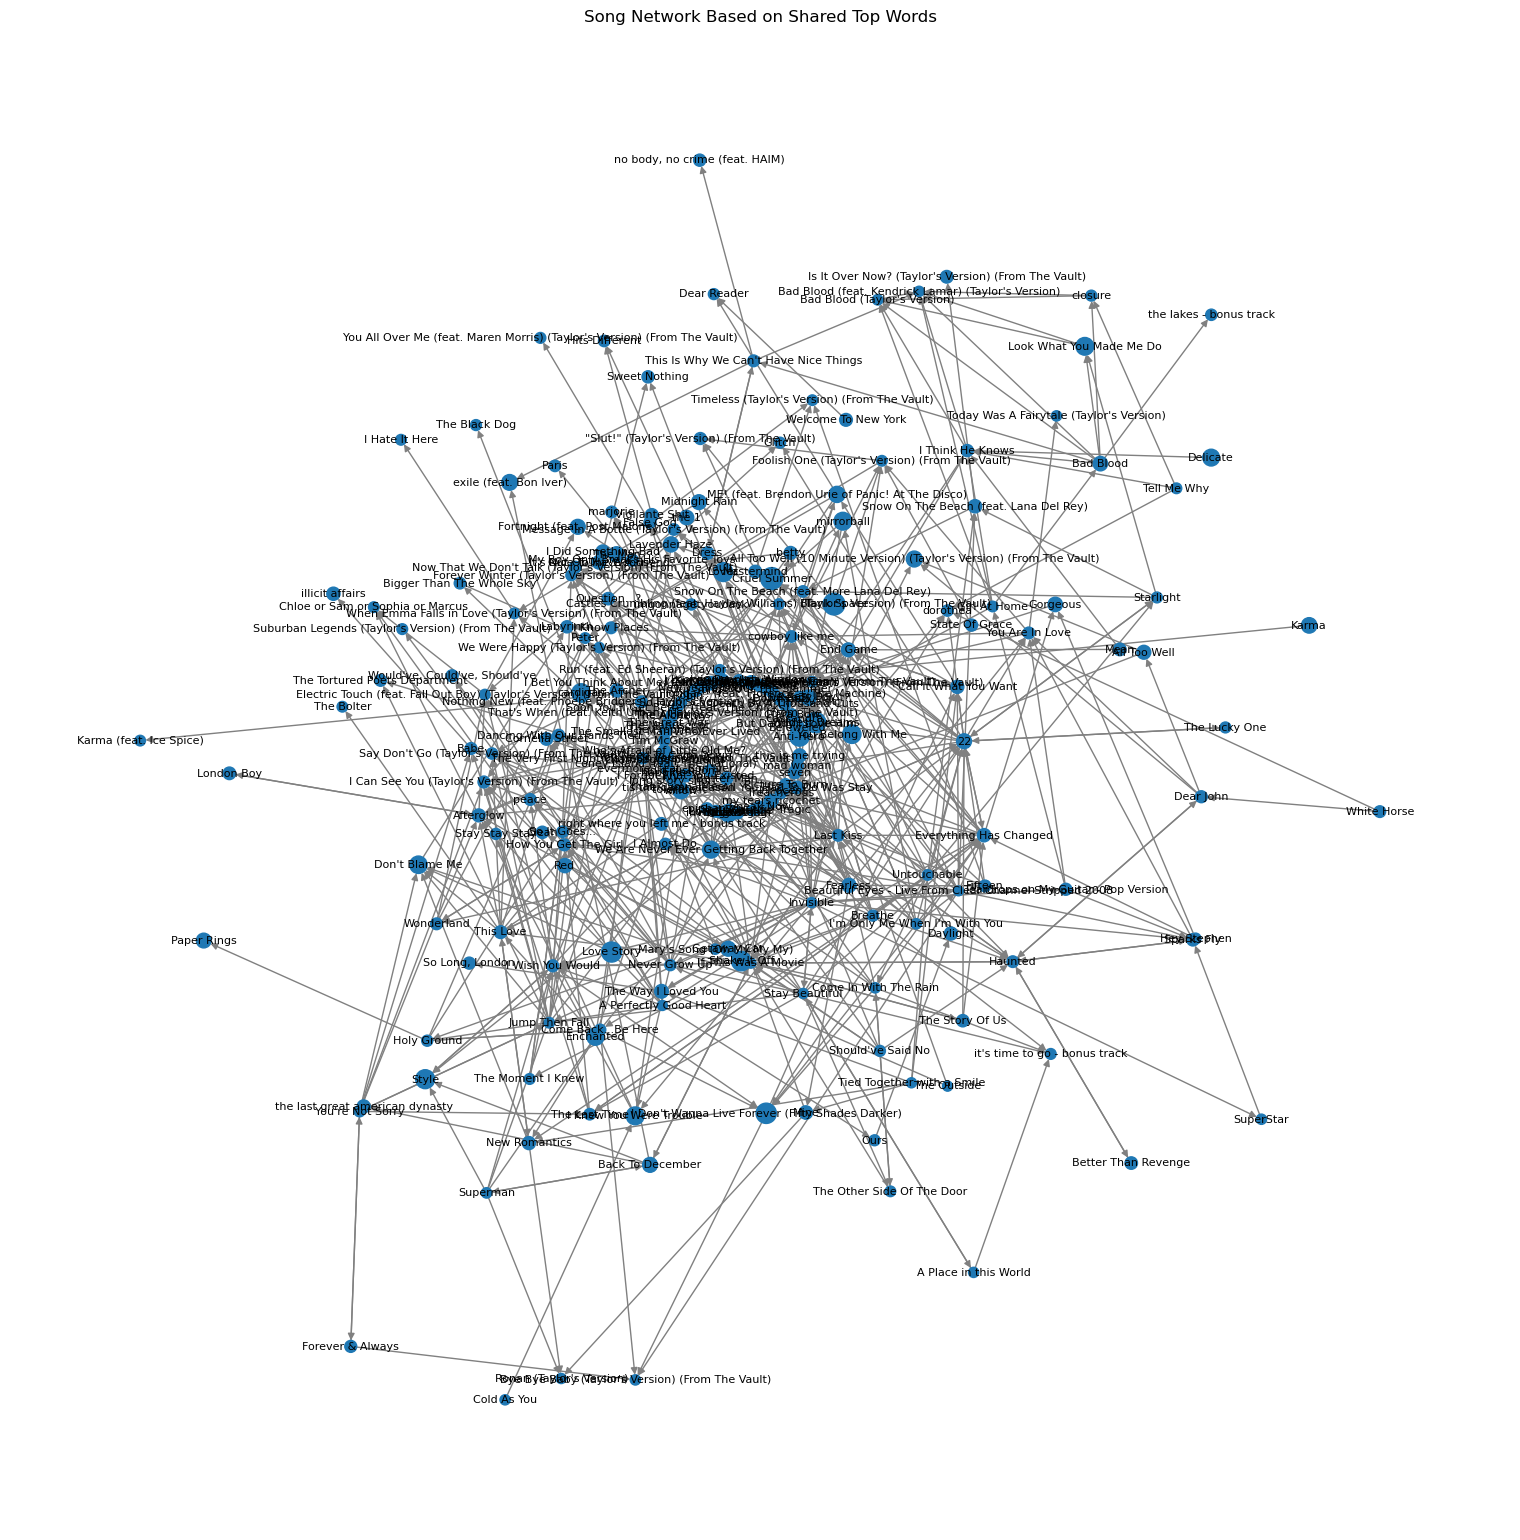

Number of nodes: 235
Number of edges: 496


In [ ]:
import networkx as nx

def build_song_network(ts_data, top_words_df, min_shared_words=1):
    """
    Builds a directed song network based on shared top words and release dates.

    Parameters:
        ts_data (DataFrame): The original dataset with song metadata, including release dates.
        top_words_df (DataFrame): DataFrame containing track names and their top words.
        min_shared_words (int): Minimum number of shared words required to create an edge.

    Returns:
        nx.DiGraph: A directed network of songs.
    """
    G = nx.DiGraph()

    # Build a mapping of song to top words
    song_to_words = dict(zip(top_words_df['track_name'], top_words_df['top_words']))

    # Add nodes to the graph
    for _, row in ts_data.iterrows():
        G.add_node(
            row['track_name'], 
            release_date=row['release_date'],
            genre=row['track_musical_genre'], 
            spotify_streams=row['spotify_streams'],
            album = row['album']
        )

    # Add edges based on shared words and release dates
    for song1, words1 in song_to_words.items():
        for song2, words2 in song_to_words.items():
            if song1 != song2:
                # Find common words between the two songs
                common_words = set([w[0] for w in words1]).intersection([w[0] for w in words2])
                if len(common_words) >= min_shared_words:
                    # Determine the direction of the edge based on release date
                    date1 = ts_data.loc[ts_data['track_name'] == song1, 'release_date'].iloc[0]
                    date2 = ts_data.loc[ts_data['track_name'] == song2, 'release_date'].iloc[0]

                    # Handle lists in release_date
                    if isinstance(date1, list):
                        date1 = min(date1)
                    if isinstance(date2, list):
                        date2 = min(date2)

                    # Add edge based on release date comparison
                    if date1 < date2:
                        G.add_edge(song1, song2, weight=len(common_words))
                    else:
                        G.add_edge(song2, song1, weight=len(common_words))

    return G

# Build the song network
net = build_song_network(updated_ts_data, top_words_df, min_shared_words=3)

node_sizes = []
for node in net.nodes:
    streams = net.nodes[node]['spotify_streams']
    if isinstance(streams, list):
        # If spotify_streams is a list, sum the values
        node_sizes.append(sum(streams))
    else:
        # If it's a single value, just append it
        node_sizes.append(streams)

# Normalize the node sizes to make them visually appropriate
max_streams = max(node_sizes)
min_streams = min(node_sizes)
print(min_streams, max_streams)
normalized_sizes = [50 + (size - min_streams) / (max_streams - min_streams) * 200 for size in node_sizes]



plt.figure(figsize=(15, 15))
pos = nx.kamada_kawai_layout(net)  
nx.draw(
    net, pos, with_labels=True, 
    node_size=normalized_sizes, font_size=8, edge_color="gray", arrowsize=10
)
plt.title("Song Network Based on Shared Top Words")
plt.show()

# Display network statistics
print(f"Number of nodes: {net.number_of_nodes()}")
print(f"Number of edges: {net.number_of_edges()}")


In [ ]:
# Save the network 
with open('song_network.pkl', 'wb') as f:
    pickle.dump(net, f)

In [ ]:
updated_ts_data.to_pickle("ts_data.pkl")
print("DataFrame saved as 'updated_ts_data.pkl'")

DataFrame saved as 'updated_ts_data.pkl'


In [ ]:
# print(updated_ts_data['spotify_streams'].apply(type).value_counts())

In [ ]:
# def normalize_streams(value):
#     if isinstance(value, list):
#         return sum(value)  # Sum the elements in the list
#     return int(value)  # Return the value as an integer

# # Apply the normalization function to the column
# updated_ts_data['spotify_streams'] = updated_ts_data['spotify_streams'].apply(normalize_streams)

# # Verify the column type again
# print(updated_ts_data['spotify_streams'].apply(type).value_counts())  # Should only show <class 'int'>
# print(updated_ts_data['spotify_streams'].dtype)  # Should show int64

In [ ]:
# import pygraphviz as pgv
# import pandas as pd
# from datetime import datetime
# import matplotlib.pyplot as plt

# def build_song_network_pygraphviz(ts_data, top_words_df, min_shared_words=1):
#     """
#     Builds a directed song network using PyGraphviz based on shared top words and release dates.

#     Parameters:
#         ts_data (DataFrame): The original dataset with song metadata, including release dates.
#         top_words_df (DataFrame): DataFrame containing track names and their top words.
#         min_shared_words (int): Minimum number of shared words required to create an edge.

#     Returns:
#         pgv.AGraph: A directed network of songs.
#     """
#     G = pgv.AGraph(directed=True)

#     # Build a mapping of song to top words
#     song_to_words = dict(zip(top_words_df['track_name'], top_words_df['top_words']))

#     # Add nodes with attributes
#     for _, row in ts_data.iterrows():
#         G.add_node(
#             row['track_name'],
#             release_date=row['release_date'],  # Add release date as an attribute
#             spotify_streams=row['spotify_streams'],  # Add Spotify streams as an attribute
#             shape="ellipse",
#         )

#     # Add edges based on shared words and release dates
#     for song1, words1 in song_to_words.items():
#         for song2, words2 in song_to_words.items():
#             if song1 != song2:
#                 # Find common words between the two songs
#                 common_words = set([w[0] for w in words1]).intersection([w[0] for w in words2])
#                 if len(common_words) >= min_shared_words:
#                     # Determine the direction of the edge based on release date
#                     date1 = ts_data.loc[ts_data['track_name'] == song1, 'release_date'].iloc[0]
#                     date2 = ts_data.loc[ts_data['track_name'] == song2, 'release_date'].iloc[0]

#                     # Handle lists in release_date
#                     if isinstance(date1, list):
#                         date1 = min(date1)
#                     if isinstance(date2, list):
#                         date2 = min(date2)

#                     # Add edge based on release date comparison
#                     if date1 < date2:
#                         G.add_edge(song1, song2, label=f"{len(common_words)} words")
#                     else:
#                         G.add_edge(song2, song1, label=f"{len(common_words)} words")

#     return G

# # Build the song network using PyGraphviz
# net = build_song_network_pygraphviz(updated_ts_data, top_words_df, min_shared_words=3)

# # Compute node sizes based on Spotify streams
# node_sizes = []
# for node in net.nodes():
#     streams = net.get_node(node).attr['spotify_streams']
#     if isinstance(streams, list):
#         node_sizes.append(sum(streams))  # Sum if multiple streams are present
#     else:
#         node_sizes.append(int(streams))  # Convert single value to int if needed

# # Normalize node sizes for visualization
# max_streams = max(node_sizes)
# min_streams = min(node_sizes)
# normalized_sizes = [50 + (size - min_streams) / (max_streams - min_streams) * 200 for size in node_sizes]

# # Assign sizes to nodes
# for i, node in enumerate(net.nodes()):
#     net.get_node(node).attr['width'] = normalized_sizes[i] / 100 
#     net.get_node(node).attr['height'] = normalized_sizes[i] / 100

# # Set general graph attributes
# net.graph_attr['label'] = "Song Network Based on Shared Top Words"
# net.graph_attr['labelloc'] = "t"
# net.graph_attr['fontsize'] = 20

# # Save and visualize the graph
# net.layout(prog='sfdp')  # Choose a layout (dot, neato, etc.)
# output_file = "song_network.png"
# net.draw(output_file)

# # Display the graph in Jupyter
# img = plt.imread(output_file)
# plt.figure(figsize=(15, 15))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

# # Display network statistics
# print(f"Number of nodes: {len(net.nodes())}")
# print(f"Number of edges: {len(net.edges())}")

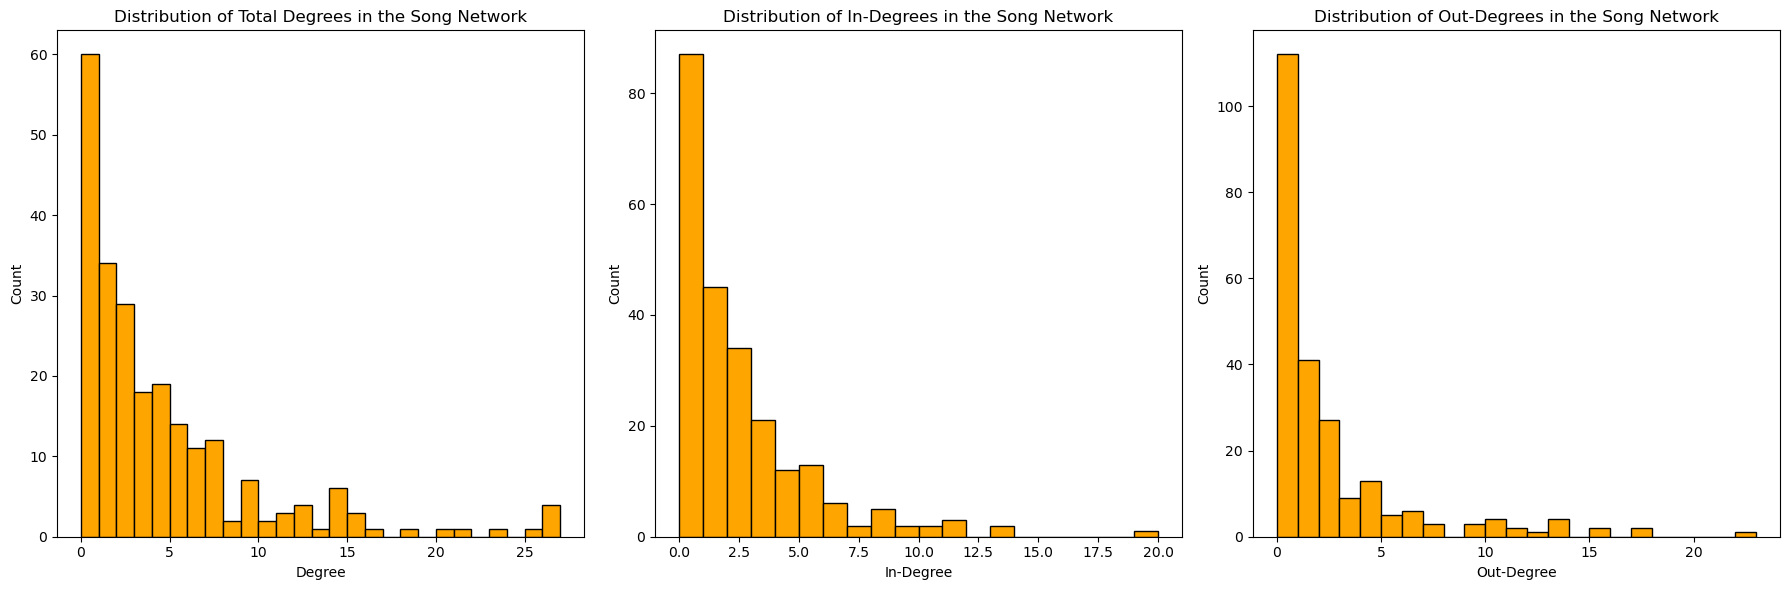

In [ ]:
# Calculate degree, in-degree, and out-degree for each node
degrees = [d for n, d in net.degree()]
in_degrees = [d for n, d in net.in_degree()]
out_degrees = [d for n, d in net.out_degree()]

# Plot degree distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Total Degree Distribution
axes[0].hist(degrees, bins=range(0, max(degrees) + 1), color='orange', edgecolor='black')
axes[0].set_title('Distribution of Total Degrees in the Song Network')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Count')

# In-Degree Distribution
axes[1].hist(in_degrees, bins=range(0, max(in_degrees) + 1), color='orange', edgecolor='black')
axes[1].set_title('Distribution of In-Degrees in the Song Network')
axes[1].set_xlabel('In-Degree')
axes[1].set_ylabel('Count')

# Out-Degree Distribution
axes[2].hist(out_degrees, bins=range(0, max(out_degrees) + 1), color='orange', edgecolor='black')
axes[2].set_title('Distribution of Out-Degrees in the Song Network')
axes[2].set_xlabel('Out-Degree')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()



In [ ]:
from tabulate import tabulate

# Find the top 5 songs with the highest in-degree
top_in_degree = sorted(net.in_degree(), key=lambda x: x[1], reverse=True)[:5]
in_degree_table = [[song, degree] for song, degree in top_in_degree]

# Find the top 5 songs with the highest out-degree
top_out_degree = sorted(net.out_degree(), key=lambda x: x[1], reverse=True)[:5]
out_degree_table = [[song, degree] for song, degree in top_out_degree]

# Print tables
print("Top 5 Songs with Highest In-Degree (Most Influenced):")
print(tabulate(in_degree_table, headers=["Song", "In-Degree"], tablefmt="grid"))

print("\nTop 5 Songs with Highest Out-Degree (Most Influential):")
print(tabulate(out_degree_table, headers=["Song", "Out-Degree"], tablefmt="grid"))


Top 5 Songs with Highest In-Degree (Most Influenced):
+------------------------------------------------------------+-------------+
| Song                                                       |   In-Degree |
+============================================================+=============+
| The Very First Night (Taylor's Version) (From The Vault)   |          20 |
+------------------------------------------------------------+-------------+
| Don't You (Taylor's Version) (From The Vault)              |          13 |
+------------------------------------------------------------+-------------+
| Better Man                                                 |          13 |
+------------------------------------------------------------+-------------+
| Run (feat. Ed Sheeran) (Taylor's Version) (From The Vault) |          11 |
+------------------------------------------------------------+-------------+
| 22                                                         |          11 |
+---------------------

# Communities

In [ ]:
# Make graph undirected
undirected_net = net.to_undirected()

In [ ]:
# Extract the Giant Connected Component (GCC)
largest_cc = max(nx.connected_components(undirected_net), key=len)
gcc = undirected_net.subgraph(largest_cc).copy()
print(f"GCC has {gcc.number_of_nodes()} nodes and {gcc.number_of_edges()} edges")

GCC has 173 nodes and 464 edges


In [ ]:
# Detect communities in the GCC
# partition = community_louvain.best_partition(gcc, random_state=42)

# # Save the partition to ensure consistency
# with open("partition.pkl", "wb") as f:
#     pickle.dump(partition, f)

# Load partitions
with open("partition.pkl", "rb") as f:
    partition = pickle.load(f)

# Compute modularity for the GCC
modularity = community_louvain.modularity(partition, gcc)
print(f"Number of communities in GCC: {len(set(partition.values()))}")
print(f"Modularity value for GCC: {modularity}")

Number of communities in GCC: 9
Modularity value for GCC: 0.4877700531340194


In [ ]:
# Group nodes by community and name them after the song with highest degree

communities = defaultdict(list)
for node, comm_id in partition.items():
    communities[comm_id].append(node)

community_names = {}
for comm_id, nodes in communities.items():
    # Compute degree for each node in the community
    degrees = {node: undirected_net.degree(node) for node in nodes}
    # Find the node with the highest degree
    highest_degree_node = max(degrees, key=degrees.get)
    community_names[comm_id] = highest_degree_node

print("Communities named by highest-degree song:")
print(community_names)


Communities named by highest-degree song:
{0: 'Invisible', 1: 'Afterglow', 2: 'Stay Beautiful', 3: 'All You Had To Do Was Stay', 4: 'I Think He Knows', 5: 'Better Man', 6: "The Very First Night (Taylor's Version) (From The Vault)", 7: 'Untouchable', 8: 'If This Was A Movie'}


/home/alesac/miniconda/envs/social_graph/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


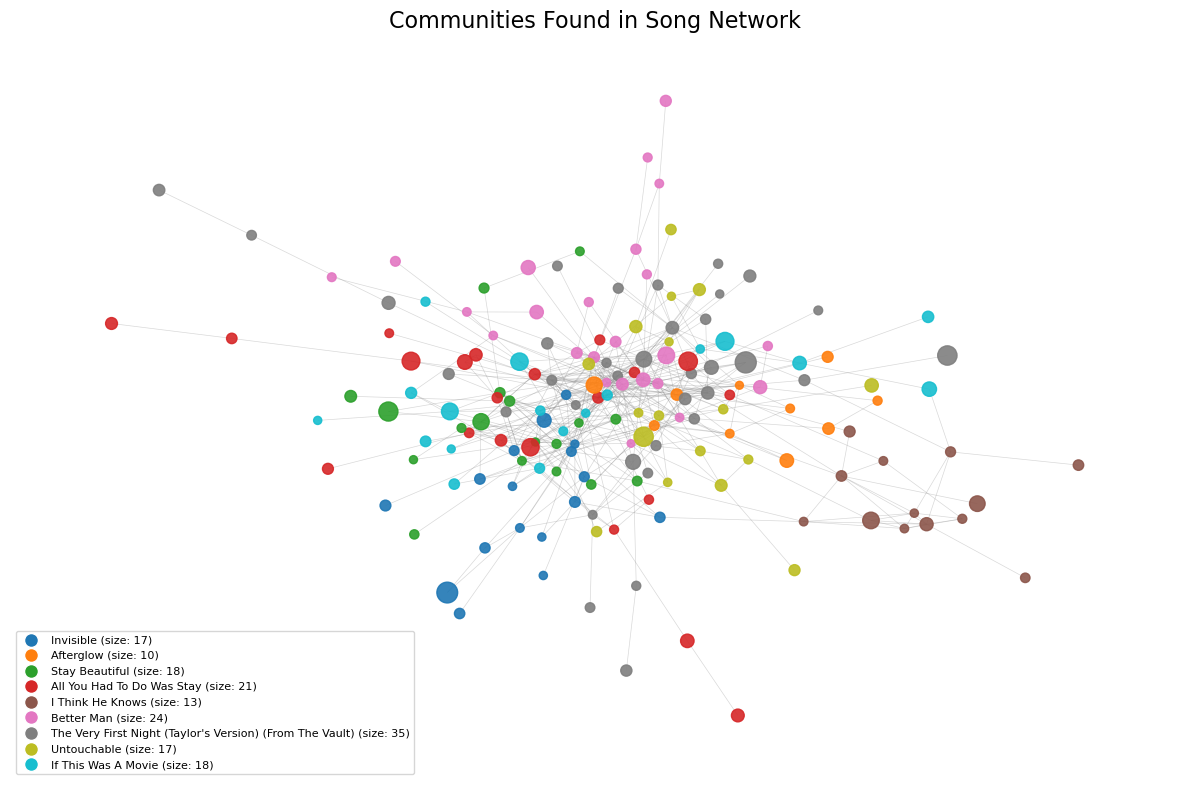

In [ ]:
# Prepare a color map for communities
num_communities = len(communities)
colors = plt.get_cmap("tab10", num_communities)

# Assign a color to each node based on its community
node_colors = [colors(partition[node]) for node in gcc.nodes()]

# Assign node sizes based on Spotify streams (or degree if not available)
node_sizes = [
    30 + (sum(gcc.nodes[node].get("spotify_streams", [1])) / 1e7) 
    if isinstance(gcc.nodes[node].get("spotify_streams"), list)
    else 30 + (gcc.nodes[node].get("spotify_streams", 1) / 1e7) 
    for node in gcc.nodes()
]

# Compute layout
pos = nx.spring_layout(gcc, seed=42)  # Force-directed layout with a fixed seed for consistency

# Plot the graph
plt.figure(figsize=(12,8))
nx.draw_networkx_nodes(
    gcc,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    cmap="tab10",
    alpha=0.9
)
nx.draw_networkx_edges(
    gcc,
    pos,
    alpha=0.3,
    edge_color="gray",
    width=0.5
)

# Add a legend for communities
handles = []
for comm_id, name in community_names.items():
    handles.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=colors(comm_id),
            markersize=10,
            label=f"{name} (size: {len(communities[comm_id])})"
        )
    )
plt.legend(
    handles=handles,
    loc="lower left",             # Align the lower-left corner of the legend
    bbox_to_anchor=(0, 0),        # To the lower-left of the axes
    ncol=1,                       # Single-column legend
    frameon=True,                 # Show legend frame
    fontsize=8,                   # Set font size
)


# Finalize and show the plot
plt.title("Communities Found in Song Network", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


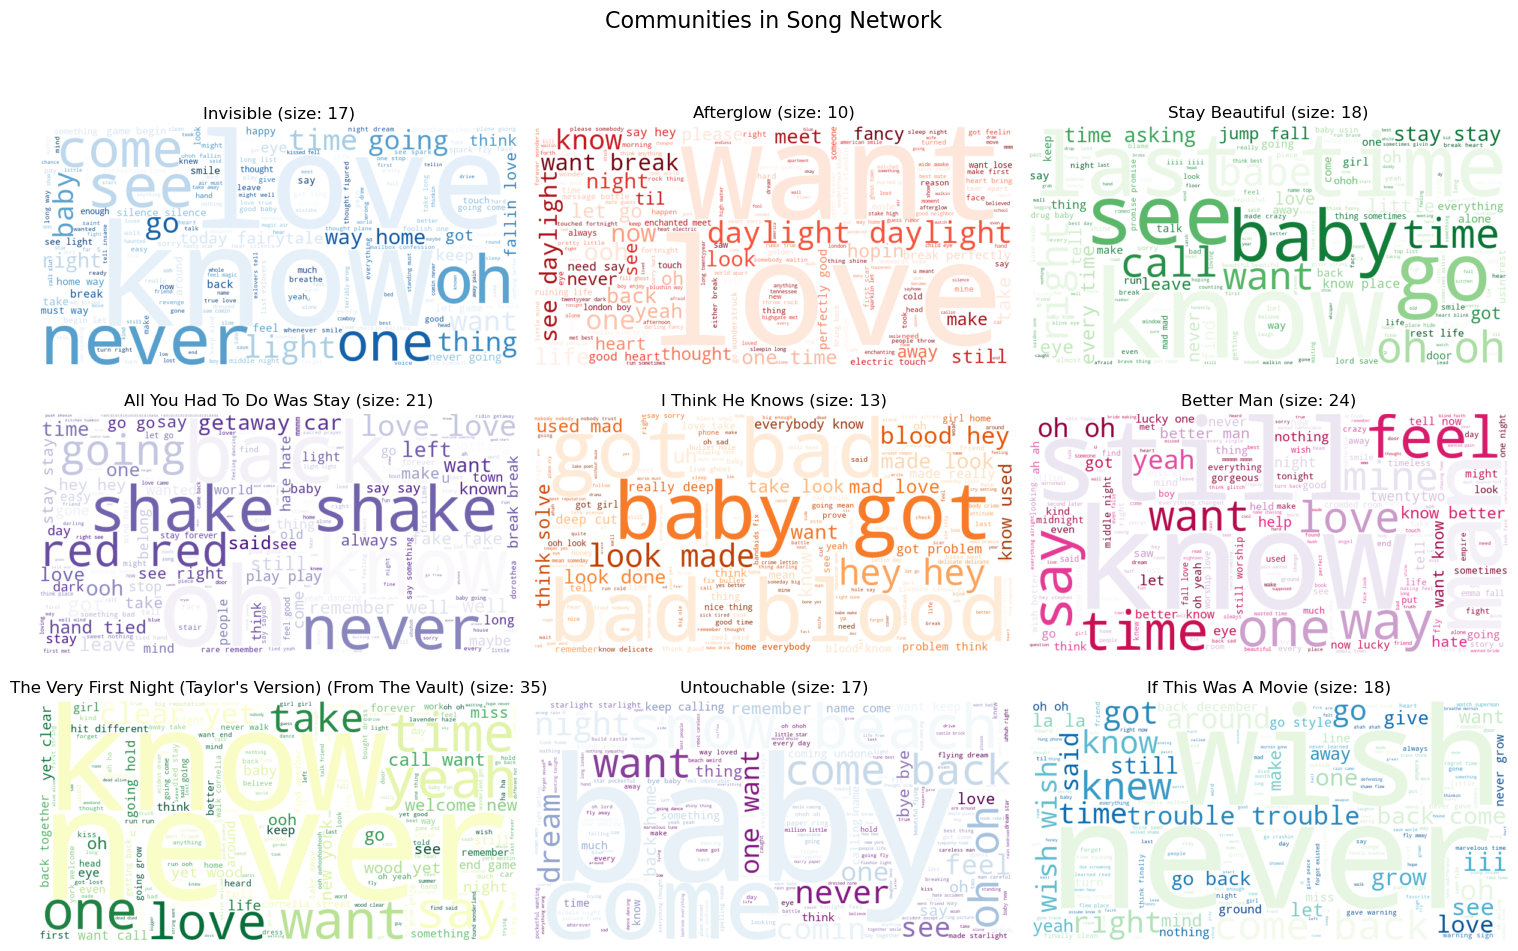

In [ ]:
# Extract lyrics for each community
community_lyrics = {}
for comm_id, nodes in communities.items():
    community_lyrics[comm_id] = " ".join(
        updated_ts_data[updated_ts_data['track_name'].isin(nodes)]['cleaned_lyrics']
    )

# Define the number of rows and columns for the grid layout
num_communities = len(community_lyrics)
rows = (num_communities // 3) + (1 if num_communities % 3 else 0)
cols = min(3, num_communities)

# Create a colormap for different colors per community
# cmap = cm.get_cmap("tab10", num_communities)
colormap_names = ["Blues", "Reds", "Greens", "Purples", "Oranges", "PuRd",  "YlGn", "BuPu", "GnBu"]

# Generate the word clouds and organize them in a grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for i, (comm_id, lyrics) in enumerate(community_lyrics.items()):
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap=colormap_names[i] ,
        random_state=42 ,
    ).generate(lyrics)
    
    # Plot the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(
        f"{community_names[comm_id]} (size: {len(communities[comm_id])})",
        color='black'  # Set the title color to match the community color
    )

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a global title
plt.suptitle("Communities in Song Network", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust spacing to fit the title
plt.show()


In [ ]:
# Function to compute word frequencies for each community
def compute_word_frequencies(community_lyrics, communities):
    community_word_data = []
    for comm_id, nodes in communities.items():
        # Tokenize lyrics for each song in the community
        community_songs = updated_ts_data[updated_ts_data['track_name'].isin(nodes)]['cleaned_lyrics']
        word_in_songs = Counter()
        total_word_counts = Counter()

        for song in community_songs:
            if isinstance(song, str):  # Ensure song is valid text
                words = set(song.split())  # Use set to avoid double-counting a word in the same song
                total_word_counts.update(song.split())
                word_in_songs.update(words)  # Count word appearances across songs

        # Most common words by total count
        most_common_total = total_word_counts.most_common(5)

        # Most common words by the number of songs they appear in
        most_common_unique = word_in_songs.most_common(5)

        # Append data for the community
        community_word_data.append({
            "Community": f"{comm_id}: {community_names[comm_id]}",
            "Most Common Words (Total Number)": most_common_total,
            "Top Words by Song Presence": most_common_unique,
            "Size": len(communities[comm_id])
        })

    return community_word_data

# Compute word frequencies for all communities
community_word_data = compute_word_frequencies(community_lyrics, communities)

# Convert to a DataFrame for visualization
df = pd.DataFrame(community_word_data)

# Extract the numeric prefix from the "Community" column and sort by it
df['Community Index'] = df['Community'].str.extract(r'^(\d+):', expand=False).astype(int)
df = df.sort_values(by='Community Index').drop(columns=['Community Index'])

# Reset the index after sorting
df = df.reset_index(drop=True)

pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', None)  


display(df)


,Community,Most Common Words (Total Number),Top Words by Song Presence,Size
0,0: Invisible,"[(love, 82), (never, 62), (know, 57), (way, 53), (like, 47)]","[(know, 14), (love, 13), (oh, 13), (like, 13), (never, 12)]",17
1,1: Afterglow,"[(want, 64), (love, 56), (daylight, 40), (would, 28), (one, 27)]","[(love, 9), (want, 8), (like, 8), (back, 7), (now, 6)]",10
2,2: Stay Beautiful,"[(time, 106), (know, 80), (oh, 68), (baby, 51), (last, 44)]","[(oh, 13), (know, 13), (you, 13), (time, 12), (got, 11)]",18
3,3: All You Had To Do Was Stay,"[(oh, 76), (love, 73), (shake, 70), (like, 66), (go, 51)]","[(oh, 17), (like, 15), (could, 14), (ever, 13), (back, 13)]",21
4,4: I Think He Knows,"[(got, 142), (hey, 116), (know, 84), (look, 84), (bad, 74)]","[(like, 12), (know, 10), (got, 10), (think, 9), (thing, 9)]",13
5,5: Better Man,"[(know, 124), (like, 101), (would, 96), (man, 57), (oh, 56)]","[(like, 21), (know, 20), (love, 16), (way, 14), (would, 14)]",24
6,6: The Very First Night (Taylor's Version) (From The Vault),"[(want, 120), (never, 110), (would, 110), (like, 108), (know, 100)]","[(know, 26), (like, 25), (would, 23), (never, 22), (say, 21)]",35
7,7: Untouchable,"[(like, 103), (oh, 84), (come, 80), (want, 62), (baby, 49)]","[(like, 16), (oh, 13), (would, 12), (you, 11), (back, 11)]",17
8,8: If This Was A Movie,"[(would, 110), (wish, 88), (never, 86), (back, 72), (i, 72)]","[(would, 14), (know, 14), (never, 13), (could, 11), (like, 11)]",18


This table highlights key patterns in the communities formed within the song network. Communities with more songs, such as *"The Very First Night (Taylor’s Version) (From The Vault)"* (35 songs), demonstrate higher cohesion, as seen in their shared common words like *"know"* and *"like"* across numerous songs. This suggests strong thematic connections within larger communities.

Interestingly, communities with fewer songs, such as *"Afterglow"* (10 songs), still exhibit distinctive common words like *"want"* and *"love"*, but these words are less prevalent across the songs, reflecting a lower degree of thematic overlap. This implies smaller communities might explore more niche or varied topics.

The table also reveals a balance between shared themes and individuality. For example, while *"Invisible"* (17 songs) emphasizes universally relatable words like *"love"* and *"never"*, communities like *"Stay Beautiful"* focus on unique terms like *"time"* and *"baby"*, potentially indicating a more specific lyrical focus.

Overall, the size of a community correlates with its connectivity and thematic density. Larger communities tend to have higher internal cohesion through shared words, whereas smaller ones exhibit a mix of distinct and shared lyrical themes. This reflects the diversity in song topics and their grouping into interconnected communities.

The Top Words by Song Presence column shows how often a word appears across songs in a community. For example, in Community 0, words like never and love appear in most songs, indicating strong cohesion and a clear shared theme.

In [ ]:
# Prepare the data for the table
community_metrics = []

for comm_id, nodes in communities.items():
    lyrics = updated_ts_data[updated_ts_data['track_name'].isin(nodes)]['cleaned_lyrics']
    
    # Calculate metrics
    num_songs = len(nodes)
    word_counts = [len(song.split()) for song in lyrics]
    num_words = sum(word_counts) / len(word_counts) if word_counts else 0
    unique_word_counts = [len(set(song.split())) for song in lyrics]
    num_unique = sum(unique_word_counts) / len(unique_word_counts) if unique_word_counts else 0
    percentage_unique = num_unique / num_words if num_words else 0
    average_length = sum(len(word) for song in lyrics for word in song.split()) / sum(word_counts) if word_counts else 0
    
    # Get the average degree in the community
    subgraph = gcc.subgraph(nodes)
    degrees = [degree for _, degree in subgraph.degree()]
    average_degree = sum(degrees) / len(degrees) if degrees else 0
    
    # Find the most common words
    all_words = Counter(word for song in lyrics for word in song.split())
    common_words = [f"{word} ({count})" for word, count in all_words.most_common(5)]
    
    # Append metrics for this community
    community_metrics.append({
        "Community": f"{comm_id}: {community_names[comm_id]}",
        "num_songs": num_songs,
        "num_words": round(num_words, 2),
        "num_unique": round(num_unique, 2),
        "percentage_unique": round(percentage_unique, 2),
        "average_length": round(average_length, 2),
        "average_degree": round(average_degree, 2),
        "common_words": ", ".join(common_words)
    })

# Create a DataFrame for the table
community_metrics_df = pd.DataFrame(community_metrics)

display(community_metrics_df)


,Community,num_songs,num_words,num_unique,percentage_unique,average_length,average_degree,common_words
0,0: Invisible,17,171.29,81.12,0.47,4.80,3.65,"love (82), never (62), know (57), way (53), like (47)"
1,1: Afterglow,10,177.40,82.40,0.46,4.95,2.60,"want (64), love (56), daylight (40), would (28), one (27)"
2,2: Stay Beautiful,18,160.72,75.33,0.47,4.55,2.89,"time (106), know (80), oh (68), baby (51), last (44)"
3,3: All You Had To Do Was Stay,21,197.90,96.00,0.49,4.73,2.48,"oh (76), love (73), shake (70), like (66), go (51)"
4,4: I Think He Knows,13,231.54,84.08,0.36,4.43,3.69,"got (142), hey (116), know (84), look (84), bad (74)"
5,5: Better Man,24,165.46,82.17,0.50,4.88,3.67,"know (124), like (101), would (96), man (57), oh (56)"
6,6: The Very First Night (Taylor's Version) (From The Vault),35,186.91,88.77,0.47,4.76,3.43,"want (120), never (110), would (110), like (108), know (100)"
7,7: Untouchable,17,186.88,83.71,0.45,4.84,2.71,"like (103), oh (84), come (80), want (62), baby (49)"
8,8: If This Was A Movie,18,188.28,87.22,0.46,4.77,3.00,"would (110), wish (88), never (86), back (72), i (72)"


This table offers an insightful analysis of the song communities in terms of lexical variety, song length, and connectivity. A positive relationship is observed between the number of words and unique words, indicating that longer songs incorporate more diverse vocabulary rather than relying on repetition. Communities with higher numbers of songs also tend to have higher average degrees, reflecting denser connections due to more shared topics within the community.

Interestingly, there is a noticeable trend where communities with shorter songs tend to have higher average degrees, suggesting that shorter songs focus on more interconnected and common themes, whereas longer songs may delve into more unique or less connected topics. These patterns highlight both the cohesion within communities and the diversity in lyrical content across them.